In [57]:
#JSMA
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2

In [ ]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    import matplotlib.pyplot as plt
    plt.figure()

    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [58]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = Variable(torch.from_numpy(img).to(device).float())
#print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

orig_label=np.argmax(model(img).data.cpu().numpy())
print("orig_label={}".format(orig_label))

print(img.data.cpu().numpy())

print(img.data.cpu().numpy().min(3))


orig_label=388
[[[[-0.83354735 -0.83354735 -0.83354735 ...  0.91317755  0.91317755
     0.91317755]
   [-0.7650483  -0.7821731  -0.7821731  ...  0.9303023   0.91317755
     0.91317755]
   [-0.61092556 -0.6280503  -0.64517504 ...  0.9303023   0.9303023
     0.91317755]
   ...
   [-0.49105227 -0.49105227 -0.49105227 ... -0.18280673 -0.18280673
    -0.18280673]
   [-0.49105227 -0.49105227 -0.49105227 ... -0.21705624 -0.19993149
    -0.19993149]
   [-0.49105227 -0.49105227 -0.49105227 ... -0.23418099 -0.21705624
    -0.19993149]]

  [[-0.79271704 -0.77521    -0.757703   ...  1.6232493   1.6057423
     1.6057423 ]
   [-0.74019605 -0.72268903 -0.705182   ...  1.6232493   1.6057423
     1.6057423 ]
   [-0.565126   -0.565126   -0.565126   ...  1.6407564   1.6232493
     1.6232493 ]
   ...
   [ 0.39775923  0.39775923  0.39775923 ... -0.24999997 -0.24999997
    -0.24999997]
   [ 0.39775923  0.39775923  0.39775923 ... -0.28501397 -0.267507
    -0.267507  ]
   [ 0.39775923  0.39775923  0.39775923 

In [59]:
#实现saliency_map
def saliency_map(F, x,t, mask):
        
        # pixel influence on target class
        F[0, t].backward(retain_graph=True)
        derivative=x.grad.data.cpu().numpy().copy()
        alphas = derivative * mask
        #mask初始是全为1的矩阵，如果该点的偏移已经到达了极限，将对应点置为0,不再参与图片的更新

        # pixel influence on sum of residual classes
        # 这里假如采用原论文的alpha×beta的办法train会失败  所以这里我们采用相加的办法。
        betas = np.zeros_like(alphas)
        for i in range(F.shape[1]):
                if x.grad is not None:
                        x.grad.zero_()
                if i!=t:
                        F[0,i].backward(retain_graph=True)
                        d=x.grad.data.cpu().numpy().copy()
                        betas+=d*mask
        betas/=9990
        sal_map = alphas-betas
        idx = np.argmin(sal_map)
        
        #这里简化了beta参数
        # betas = -np.ones_like(alphas)
        # sal_map = np.abs(alphas) * np.abs(betas) * np.sign(alphas * betas)
        # idx = np.argmin(sal_map)
        
        #转换成(p1,p2)格式      
        idx = np.unravel_index(idx, mask.shape)
        pix_sign = np.sign(alphas)[idx]
    
        return idx, pix_sign


In [60]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False

epochs=2000
#扰动系数
theta=0.3


#攻击目标
target_label=288
target=Variable(torch.Tensor([float(target_label)]).to(device).long())

loss_func = torch.nn.CrossEntropyLoss()


# the mask defines the search domain
# each modified pixel with border value is set to zero in mask
mask = np.ones_like(img.data.cpu().numpy())

#定义边界
max_=3.0
min_=-3.0

for epoch in range(epochs):
    
    # forward 
    output = model(img)
    
    label=np.argmax(output.data.cpu().numpy())
    loss = loss_func(output, target)
    print("epoch={} label={} loss={}".format(epoch,label,loss))
    
    #如果定向攻击成功
    if label == target_label:
        break
   
    #梯度清零
    if img.grad is not None:
        img.grad.zero_()

    idx, pix_sign=saliency_map(output, img,target_label, mask)
       
    # apply perturbation 
    img.data[idx]=img.data[idx]+pix_sign * theta * (max_ - min_) 
    
    #达到极限的点不再参与更新
    if (img.data[idx]<=min_) or (img.data[idx]>=max_):
        print("idx={} over {}".format(idx,img.data[idx]))
        mask[idx]=0
        img.data[idx]=np.clip(img.data[idx], min_, max_)

epoch=0 label=388 loss=12.659759521484375
epoch=1 label=388 loss=12.682426452636719
epoch=2 label=388 loss=12.730052947998047
idx=(0, 1, 68, 144) over -3.345518112182617
epoch=3 label=388 loss=12.772210121154785
idx=(0, 1, 52, 196) over -3.5205881595611572
epoch=4 label=388 loss=12.819554328918457
epoch=5 label=388 loss=12.857293128967285
epoch=6 label=388 loss=12.79119873046875
epoch=7 label=388 loss=12.808794975280762
epoch=8 label=388 loss=12.738930702209473
epoch=9 label=388 loss=12.780617713928223
epoch=10 label=388 loss=12.742219924926758
epoch=11 label=388 loss=12.64899730682373
epoch=12 label=388 loss=12.582767486572266
epoch=13 label=388 loss=12.586419105529785
epoch=14 label=388 loss=12.533716201782227
epoch=15 label=388 loss=12.482983589172363
epoch=16 label=388 loss=12.374774932861328
epoch=17 label=388 loss=12.287715911865234
epoch=18 label=388 loss=12.204422950744629
epoch=19 label=388 loss=12.225683212280273
epoch=20 label=388 loss=12.094961166381836
idx=(0, 1, 76, 175) 

(3, 224, 224)
l0=655 l2=4495.722856226794


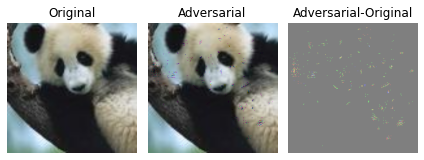

In [61]:

adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean

adv = adv * 256.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

show_images_diff(orig,orig_label,adv,target_label)